In [63]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState)
from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
                                        StabilizingLQRController)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

from underactuated import FindResource, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()


In [64]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [65]:
mc = 10
mp = 1
l = 0.5
gravity = 9.81

In [66]:
prog_create = MathematicalProgram()
x = prog_create.NewIndeterminates(4, 'X')
xd = prog_create.NewIndeterminates(4, 'Xd')
u = prog_create.NewIndeterminates(1, 'u')

dynamics = np.array([[xd[0] - x[2]], 
                     [xd[1] - (1 + x[1]**2)*x[3]/2], 
                     [(1 + x[1]**2)*(mc + mp)*xd[2] - mp*l*(1 - x[1]**2)*xd[3] \
                      + 2*mp*l*x[1]*x[3]**2 - (1 + x[1]**2)*u[0]], 
                     [-mp*l*(1 - x[1]**2)*xd[2] + mp*l**2*(1 + x[1]**2)*xd[3] - mp*gravity*l*2*x[1]]])

M = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, (1 + x[1]**2)*(mc+mp), -mp*l*(1 - x[1]**2)], 
              [0, 0, -mp*l*(1 - x[1]**2), mp*l**2*(1 + x[1]**2)]])

p_dot = 0.5*(1 + x[1]**2)*x[3]

Mdot = np.array([[0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, (x[1]*2)*(mc+mp)*p_dot, 2*mp*l*x[1]*p_dot], 
              [0, 0, 2*mp*l*x[1]*p_dot, 2*mp*l**2*x[1]*p_dot]])

f = np.array([[x[2] + 0], 
              [(1 + x[1]**2)*x[3]/2], 
              [- 2*mp*l*x[1]*x[3]**2 + (1 + x[1]**2)*u[0]], 
              [mp*gravity*l*2*x[1]]])

env = {x[0]:0, x[1]:0, x[2]:0, x[3]:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, u[0]:0}
A_general = []
for exp in f: 
    exp_curr = exp[0].Jacobian(x)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A[i, j] = elem.Evaluate(env)
        
A = np.array(A, dtype=float)

E_general = []
for exp in dynamics: 
    exp_curr = exp[0].Jacobian(xd)
    E_general.append(exp_curr)
E_general = np.array(E_general)  

E = np.zeros_like(E_general)
for i, row in enumerate(E_general): 
    for j, elem in enumerate(row): 
        E[i, j] = elem.Evaluate(env)
        
E = np.array(E, dtype=float)

B = np.array([[0], 
              [0], 
              [1], 
              [0]])

In [67]:
Q = np.diag([10, 10, 0, 0])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [68]:
K

array([[ -3.16227766, 508.19361218,  -9.70810764,  55.10499085]])

In [69]:
A_cloop = A - B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E=E.T)

np.linalg.eigvals(P)

array([3.56131853e+02, 1.30005328e+00, 1.71739920e+00, 1.16587049e-03])

In [70]:
V = x.T@E.T@P@E@x
V = Polynomial(V)

In [71]:
u = -K@x
u = -B.T@X@M@x

f = np.array([[x[2] + 0], 
              [(1 + x[1]**2)*x[3]/2], 
              [- 2*mp*l*x[1]*x[3]**2 + (1 + x[1]**2)*u[0]], 
              [mp*gravity*l*2*x[1]]])

Vdot = f.T@P@M@x + x.T@Mdot.T@P@M@x + x.T@M.T@P@Mdot@x + x.T@M.T@P@f
Vdot = Polynomial(Vdot[0])

In [89]:
def cartpole_balancing_example(x, K, M, B, X, UseNew):
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state

    def Controllability(plant):

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])
        plant.SetPositionsAndVelocities(context, UprightState())

        linearized_plant = Linearize(
            plant,
            context,
            input_port_index=plant.get_actuation_input_port().get_index(), output_port_index=plant.get_state_output_port().get_index())
        print(linearized_plant.A())
        print(linearized_plant.B())
        print(
            f"The singular values of the controllability matrix are: {np.linalg.svd(ControllabilityMatrix(linearized_plant), compute_uv=False)}"
        )

    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        plant.SetPositionsAndVelocities(context, UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = np.array([1])

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())

    xc = Variable('xc')
    tc = Variable('tc')
    xd = Variable('xd')
    td = Variable('td')
    garbage = Variable('garbage')
    
    st = np.hstack([xc, tc, xd, td])
    K2 = B.T@X@M
    u2 = -K2@x
    u  = -K@x
    
    subs = {}
    subs[x[0]] = xc
    subs[x[1]] = pf.sin(tc - np.pi)/(1+pf.cos(tc - np.pi))
    subs[x[2]] = xd
    subs[x[3]] = td
    u2 = u2[0].Substitute(subs)
    u = u[0].Substitute(subs)
    #print(u2)
    own_controller_new = SymbolicVectorSystem(state=[garbage], input=st, dynamics=np.array([0]), output=[u2])
    
    own_controller = SymbolicVectorSystem(state=[garbage], input=st, dynamics=np.array([0]), output=[u])
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()

    
    if UseNew: 
        controller = builder.AddSystem(own_controller_new)
    else: 
        controller = builder.AddSystem(BalancingLQR(plant))
    builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_actuation_input_port())

#     # Setup visualization
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    logger = LogVectorOutput(plant.get_state_output_port(), builder)
    
    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 20
    
    x_lim = np.linspace(-60, 60, 300)
    t_lim = np.linspace(np.pi/2, 3*np.pi/2, 300)
    X_lim, T_lim = np.meshgrid(x_lim, t_lim)
    
    works = np.zeros_like(X_lim)
    for i in range(len(X_lim)):
        for j in range(len(X_lim[i])): 
            try: 
                context.SetTime(0.)
                trial = np.array([X_lim[i, j], T_lim[i, j], 0, 0])
                plant.SetPositionsAndVelocities(plant_context,trial)
                simulator.Initialize()
                simulator.AdvanceTo(duration)
                
                log = logger.FindLog(context)
                end_state = log.data()[:, -1]
    #             print(end_state)
                diff = np.abs(end_state - UprightState())
    #             print(diff)
                if np.sum(diff < np.ones(4)*5e-2) == 4: 
                    works[i, j] = 1
            except: 
                pass
        print(i)
    return X_lim, T_lim, works

X_lim, T_lim, works = cartpole_balancing_example(x, K, M, B, X, True)
np.save('new_sim_cart_new.npy', works)
X_lim, T_lim, works_LQR = cartpole_balancing_example(x, K, M, B, X, False)
np.save('new_sim_cart.npy', works_LQR)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [90]:
works_LQR

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
succ_indices_LQR = np.where(works_LQR == 1)
succ_indices = np.where(works == 1)

<IPython.core.display.Javascript object>


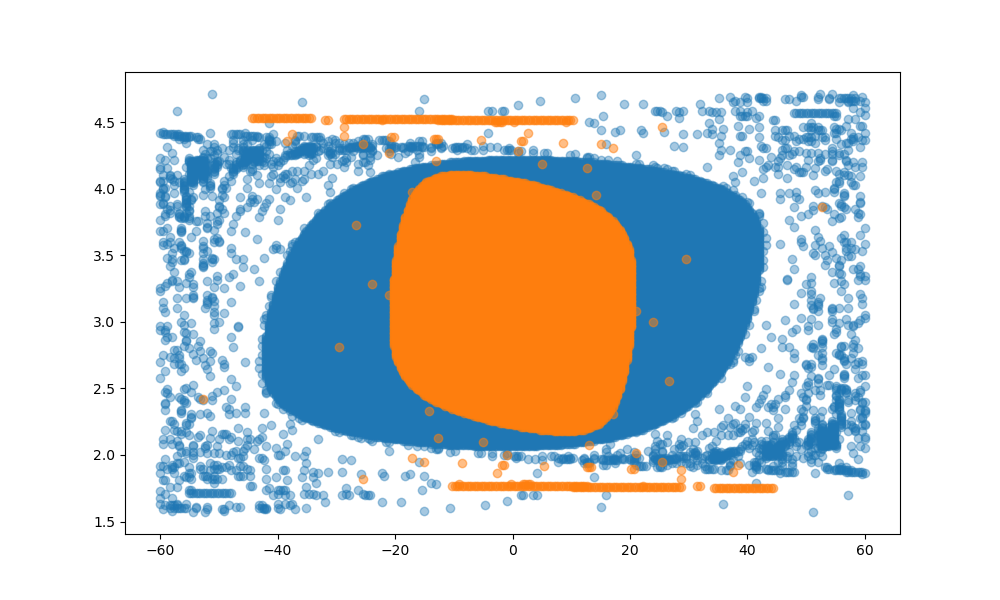

In [92]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


img = ax.scatter(X_lim[succ_indices_LQR], T_lim[succ_indices_LQR], alpha=0.4)
img2 = ax.scatter(X_lim[succ_indices], T_lim[succ_indices], alpha=0.5)


In [ ]:
def UprightState():
    return np.array([0, np.pi, 0, 0])

def cart_pole_sim(use_new, num_samples, plotting):
    # defining the controller

    x = Variable("x")
    theta = Variable("t")
    xdot = Variable("\dot{x}")
    thetadot = Variable("\dot{t}")
    u_symbolic = Variable("u")
    garbage = Variable("garbage")

    x = np.hstack([x, theta, xdot, thetadot])
    u = -K@(x  - UprightState())
    own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)
    
    M = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*pf.cos(theta)], 
             [0, 0, l*mp*pf.cos(theta), l**2*mp]])
    K2 = B.T@X@M
    u2 = -K2@(x - UprightState())
    own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u2)

    #defining the system
    exp_dynamics = np.array([xdot, 
                             thetadot, 
                             (1/(mc+mp*(pf.sin(theta))**2))*(u_symbolic + \
                                                mp*pf.sin(theta)*(l*thetadot**2+gravity*pf.cos(theta))),
                             (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])
    system = SymbolicVectorSystem(state=x, input=[u_symbolic], dynamics=exp_dynamics, output=x)



    builder = DiagramBuilder()
    # plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    # file_name = FindResource("models/cartpole.urdf")
    # Parser(plant).AddModelFromFile(file_name)
    # plant.Finalize()
    # print('Plant Finalised')

    plant = builder.AddSystem(system)
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else: 
        controller = builder.AddSystem(own_controller)
    builder.Connect(plant.get_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_input_port())

    logger = LogVectorOutput(plant.get_output_port(), builder)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    #plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 50
    

    XR = np.linspace(-70, 70, num_samples)
    TR = np.linspace(1, 5, num_samples)
    XR1, TR1 = np.meshgrid(XR, TR)

    success_list = np.zeros_like(XR1)

    for i in range(len(XR1)):
        for j in range(len(XR1[i])): 

            context.SetTime(0.)

            trial = np.array([XR1[i, j], TR1[i, j], 0, 0, 0])
            context.SetContinuousState(trial)
            simulator.Initialize()
            simulator.AdvanceTo(duration)

            log = logger.FindLog(context)
            end_state = log.data()[:, -1]
            diff = np.abs(end_state - UprightState())

            tolerance = 5e-2

            if np.sum(diff < np.ones(4)*tolerance) == 4: 
                success_list[i, j] = 1


            if plotting: 
                plt.figure(figsize=(5, 4))
                plt.plot(log.sample_times(), log.data().transpose())
                plt.xlabel('t')
                plt.ylabel('y(t)')
            print(j)
        
        print(i)
            
    return success_list, TR1, XR1

print('HERE')
init_time = time.time()
success_list, TR1, XR1 = cart_pole_sim(False, 200, False)
np.save('cartpole300by300_expanded.npy', success_list)
end_time = time.time() - init_time
print(end_time)
success_list, TR1, XR1 = cart_pole_sim(True, 200, False)
np.save('cartpole300by300_new_expanded.npy', success_list)
end_time = time.time() - end_time